# Recurrent Neural Networks and their invariants

We'll consider two main kinds of recurrent architectures:
* Simple RNNs
* Long Short-Term Memory (LSTM)

They feature different kinds of equivariance, and we'll compare them on the same
Time Series prediction task.

### Library imports

In [1]:
using CSV, Dates, DataFrames, Flux, Gadfly, Statistics

In [2]:
Gadfly.set_default_plot_size(600, 400)

## Example Dataset

The dataset is due to Jaganadh Gopinadhan who collected energy consumption from smart meters in his apartment:
https://www.kaggle.com/datasets/jaganadhg/house-hold-energy-data

In [3]:
df_raw = CSV.read("D202.csv", dateformat="mm/dd/yyyy", DataFrame)

Row,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES
,String15,Date,String7,String7,Float64,String3,String7,Missing
1,Electric usage,2016-10-22,0:00,0:14,0.01,kWh,$0.00,missing
2,Electric usage,2016-10-22,0:15,0:29,0.01,kWh,$0.00,missing
3,Electric usage,2016-10-22,0:30,0:44,0.01,kWh,$0.00,missing
4,Electric usage,2016-10-22,0:45,0:59,0.01,kWh,$0.00,missing
5,Electric usage,2016-10-22,1:00,1:14,0.01,kWh,$0.00,missing
6,Electric usage,2016-10-22,1:15,1:29,0.01,kWh,$0.00,missing
7,Electric usage,2016-10-22,1:30,1:44,0.01,kWh,$0.00,missing
8,Electric usage,2016-10-22,1:45,1:59,0.01,kWh,$0.00,missing
9,Electric usage,2016-10-22,2:00,2:14,0.02,kWh,$0.00,missing


In [4]:
df = combine(groupby(df_raw, "DATE"), "USAGE" => sum)

Row,DATE,USAGE_sum
,Date,Float64
1,2016-10-22,4.52
2,2016-10-23,23.32
3,2016-10-24,7.16
4,2016-10-25,8.68
5,2016-10-26,5.04
6,2016-10-27,5.32
7,2016-10-28,4.64
8,2016-10-29,10.64
9,2016-10-30,7.44


In [5]:
train_end = 550
df_train, df_test = df[1:train_end, :], df[train_end:end, :]
df_test[1, :]

Row,DATE,USAGE_sum
,Date,Float64
1,2018-04-24,10.32


In [6]:
function plot_compare(xs, ys)
  plot(layer(df_train, x=:DATE, y=:USAGE_sum, Geom.line, color=[colorant"cyan"]),
       layer(df_test,  x=:DATE, y=:USAGE_sum, Geom.line, color=[colorant"yellow"]),
       layer(x=xs, y=ys, Geom.line, color=[colorant"green"]))
end
plot_compare([], [])

Plot(...)

In [7]:
# Utility functions

# wrapping in `sin` to "normalize" to [-1, 1]
expand_date(d) = [sin(day(d)), sin(month(d)), sin(year(d))]

loss(model, row) = mean(abs2.(model(row[:DATE]) .- row[:USAGE_sum]))

function train_model!(model)
  opt_state = Flux.setup(Adam(), model)
  # 50 epochs
  for epoch in 1:50
    Flux.train!(loss, model, eachrow(df_train), opt_state)
  end
end

train_model! (generic function with 1 method)

In [8]:
expand_date(df_test[1, :DATE])

3-element Vector{Float64}:
 -0.9055783620066239
 -0.7568024953079282
  0.890078059172214

In [9]:
baseline = Chain(
  expand_date,
  Dense(3 => 5, σ),
  Dense(5 => 1)
)

Chain(
  expand_date,
  Dense(3 => 5, σ),                     # 20 parameters
  Dense(5 => 1),                        # 6 parameters
)                   # Total: 4 arrays, 26 parameters, 360 bytes.

In [10]:
baseline(df_test[1, :DATE])

┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(3 => 5, σ)
│   summary(x) = 3-element Vector{Float64}
└ @ Flux C:\Users\gabriel\.julia\packages\Flux\EHgZm\src\layers\stateless.jl:60


1-element Vector{Float32}:
 0.6067587

In [11]:
loss(baseline, df_test[1, :])

94.34705628545088

In [12]:
sum([loss(baseline, row) for row in eachrow(df_test)])

16027.561627876154

In [13]:
train_model!(baseline)

Internal error: encountered unexpected error in runtime:
BoundsError(a=Array{Core.Compiler.VarState, (4,)}[Core.Compiler.VarState(typ=Zygote.Pullback{Tuple{typeof(Base.get), Base.Dict{Symbol, Int64}, Symbol, Nothing}, Any}, undef=false), Core.Compiler.VarState(typ=Core.Const(val=nothing), undef=false), Core.Compiler.VarState(typ=Core.Const(val=nothing), undef=false), Core.Compiler.VarState(typ=Core.Const(val=nothing), undef=false)], i=(5,))
ijl_bounds_error_ints at C:/workdir/src\rtutils.c:194
setindex! at .\array.jl:969 [inlined]
stoverwrite1! at .\compiler\typelattice.jl:599
typeinf_local at .\compiler\abstractinterpretation.jl:2876
typeinf_nocycle at .\compiler\abstractinterpretation.jl:2957
_typeinf at .\compiler\typeinfer.jl:246
typeinf at .\compiler\typeinfer.jl:216
typeinf_ext at .\compiler\typeinfer.jl:1058
typeinf_ext_toplevel at .\compiler\typeinfer.jl:1091
typeinf_ext_toplevel at .\compiler\typeinfer.jl:1087
jfptr_typeinf_ext_toplevel_18220.clone_1 at C:\opt\julia-1.9.0\lib\

In [14]:
loss(baseline, df_test[1, :])

0.026912335914808412

In [15]:
sum([loss(baseline, row) for row in eachrow(df_test)])

3648.203613356865

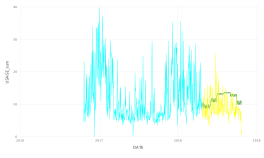

In [16]:
baseline_predictions = map(only, baseline.(df_test[:, :DATE]))
baseline_plot = plot_compare(df_test[:, :DATE], baseline_predictions)
draw(SVG(1000px, 600px), baseline_plot)

## Simple RNN

$$
\mathbf{h}^{(t)} = R(\mathbf{z}^{(t)}, \mathbf{h}^{(t-1)})
$$

$$
\mathbf{h}^{(t)} = \sigma(\mathbf{W} \mathbf{z}^{(t)} + \mathbf{U} \mathbf{h}^{(t-1)} + \mathbf{b})
$$

where $\mathbf{W} \in \mathbb{R}^{k \times m}$, $\mathbf{U} \in \mathbb{R}^{m \times m}$, and $\mathbf{b} \in \mathbb{R}^m$ are learnable parameters.

In [17]:
struct SRNN
  W :: Matrix{Float64}
  U :: Matrix{Float64}
  b :: Vector{Float64}
end
Flux.@functor SRNN

In [18]:
SRNN(k::Int, m::Int) = SRNN(rand(m, k), rand(m, m), rand(m))

SRNN

In [19]:
function (m::SRNN)(h::Vector{Float64}, z::Vector{Float64})
  h1 = σ.(m.W*z .+ m.U*h .+ m.b)
  h1, h1
end

In [20]:
H_SIZE = 20
srnn = SRNN(3, H_SIZE)
srnn(rand(H_SIZE), rand(3))

([0.9889678239658811, 0.9928532579257985, 0.9869470286692433, 0.9944894242818457, 0.9942181517546577, 0.9908173529220239, 0.9935577713794941, 0.9963085989138513, 0.9841596599534662, 0.9790702044317703, 0.992139638505, 0.9916991162887967, 0.9969894184467272, 0.9948062158648668, 0.9461371037178866, 0.9944571691232803, 0.9823771373354659, 0.9908326509471338, 0.9936551672775802, 0.9968447284633729], [0.9889678239658811, 0.9928532579257985, 0.9869470286692433, 0.9944894242818457, 0.9942181517546577, 0.9908173529220239, 0.9935577713794941, 0.9963085989138513, 0.9841596599534662, 0.9790702044317703, 0.992139638505, 0.9916991162887967, 0.9969894184467272, 0.9948062158648668, 0.9461371037178866, 0.9944571691232803, 0.9823771373354659, 0.9908326509471338, 0.9936551672775802, 0.9968447284633729])

In [21]:
rnn_model = Chain(
  expand_date,
  Flux.Recur(srnn, zeros(H_SIZE)),
  Dense(H_SIZE => 1)
)

Chain(
  expand_date,
  Recur(
    SRNN([0.07023550283627555 0.5684914869202224 0.11800846819180544; 0.8602408755814809 0.0021086882457542755 0.7883266418615336; … ; 0.5867238396557651 0.7297332387437837 0.5404720757572826; 0.6117711961260416 0.8331635629778584 0.605179270608994], [0.5077906776418049 0.3085391210112617 … 0.14763265622999067 0.9275200711075164; 0.5046452354758264 0.5207004507100876 … 0.3508372417389979 0.5644886978129385; … ; 0.10423418239411841 0.4013547122197727 … 0.32220158013641875 0.6900770613333485; 0.19423472255868968 0.9427279842058526 … 0.002901417278932117 0.9610433526576587], [0.8276084062530781, 0.08213706460720793, 0.4096061439482471, 0.6062788688680342, 0.42425212609016605, 0.6584022303164121, 0.7495903215021865, 0.025622050280189823, 0.604614668678216, 0.6395195979340736, 0.18143770818993388, 0.22185609917212545, 0.9705458530545702, 0.28393530728391825, 0.021124714583921955, 0.8168378309176324, 0.10597068097709428, 0.7710306118784821, 0.6217396125602253, 

In [22]:
loss(rnn_model, df_test[1, :])

115.77680211567044

In [23]:
sum([loss(rnn_model, row) for row in eachrow(df_test)])

20313.031136553225

In [24]:
#Flux.reset!(rnn_model)
train_model!(rnn_model)

In [25]:
loss(rnn_model, df_test[1, :])

2.877139956191399

In [26]:
sum([loss(rnn_model, row) for row in eachrow(df_test)])

4410.015192922573

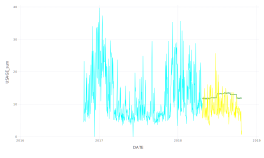

In [27]:
rnn_predictions = map(only, rnn_model.(df_test[:, :DATE]))
rnn_plot = plot_compare(df_test[:, :DATE], rnn_predictions)
draw(SVG(1000px, 600px), rnn_plot)

### Translation equivariance

$$
\mathbf{z}'^{(t)} = \mathbf{z}^{(t+1)}
$$
$$
\mathbf{h}'^{(t)} \neq \mathbf{h}^{(t+1)}
$$

$$
\mathbf{h}'^{(1)} = R(\mathbf{z}'^{(1)}, \mathbf{h}^{(0)}) = R(\mathbf{z}^{(2)}, \mathbf{h}^{(0)})
$$
$$
\mathbf{h}^{(2)} = R(\mathbf{z}^{(2)}, \mathbf{h}^{(1)}) = R(\mathbf{z}^{(2)}, R(\mathbf{z}^{(1)}, \mathbf{h}^{(0)}))
$$

$$
\overline{\mathbf{z}}^{(t)} =
\begin{cases}
\mathbf{0}            & \quad t \leq t' \\
\mathbf{z}^{(t - t')} & \quad t > t'
\end{cases}
$$

$$
\overline{\mathbf{z}}'^{(t)} = \overline{\mathbf{z}}^{(t+1)}
$$

$$
\mathbf{h}'^{(1)} = R(\overline{\mathbf{z}}'^{(1)}, \mathbf{h}^{(0)}) = R(\overline{\mathbf{z}}^{(2)}, \mathbf{h}^{(0)})
$$
$$
\mathbf{h}^{(2)} = R(\overline{\mathbf{z}}^{(2)}, \mathbf{h}^{(1)}) = R(\overline{\mathbf{z}}^{(2)}, R(\overline{\mathbf{z}}^{(1)}, \mathbf{h}^{(0)})) = R(\overline{\mathbf{z}}^{(2)}, R(\mathbf{0}, \mathbf{h}^{(0)}))
$$

$$
\mathbf{h}^{(0)} = R(\mathbf{0}, \mathbf{h}^{(0)}) \implies \mathbf{h}'^{(t)} = \mathbf{h}^{(t+1)}
$$

## Long Short-Term Memory

![LSTM](LSTM1.png)

```julia
c = F(z, c)
```

```julia
c = z & f(z, c) | c & g(z, c)
```

$c' = z \odot mask_1 \oplus c \odot mask_2$

$$
\mathbf{c}^{(t)} = \mathbf{i}^{(t)} \odot \widetilde{\mathbf{c}}^{(t)} + \mathbf{f}^{(t)} \odot \mathbf{c}^{(t-1)}
$$
$$
\mathbf{h}^{(t)} = \mathbf{o}^{(t)} \odot \mathrm{tanh}(\mathbf{c}^{(t)})
$$

$$
\widetilde{\mathbf{c}}^{(t)} = \mathrm{tanh}(\mathbf{W}_c \mathbf{z}^{(t)} + \mathbf{U}_c \mathbf{h}^{(t-1)} + \mathbf{b}_c)
$$

$$
\mathbf{i}^{(t)} = \mathrm{\sigma}(\mathbf{W}_i \mathbf{z}^{(t)} + \mathbf{U}_i \mathbf{h}^{(t-1)} + \mathbf{b}_i)
$$
$$
\mathbf{f}^{(t)} = \mathrm{\sigma}(\mathbf{W}_f \mathbf{z}^{(t)} + \mathbf{U}_f \mathbf{h}^{(t-1)} + \mathbf{b}_f)
$$
$$
\mathbf{o}^{(t)} = \mathrm{\sigma}(\mathbf{W}_o \mathbf{z}^{(t)} + \mathbf{U}_o \mathbf{h}^{(t-1)} + \mathbf{b}_o)
$$

$$
(\mathbf{h}^{(t)}, \mathbf{c}^{(t)}) = R(\mathbf{z}^{(t)}, (\mathbf{h}^{(t-1)}, \mathbf{c}^{(t-1)}))
$$

### Implementation

In [28]:
struct GLSTM
  Wc::Matrix{Float64}; Wi::Matrix{Float64}; Wf::Matrix{Float64}; Wo::Matrix{Float64}
  Uc::Matrix{Float64}; Ui::Matrix{Float64}; Uf::Matrix{Float64}; Uo::Matrix{Float64}
  bc::Vector{Float64}; bi::Vector{Float64}; bf::Vector{Float64}; bo::Vector{Float64}
end
Flux.@functor GLSTM

In [29]:
GLSTM(k::Int, m::Int) = GLSTM(
  rand(m, k), rand(m, k), rand(m, k), rand(m, k),
  rand(m, m), rand(m, m), rand(m, m), rand(m, m),
  rand(m), rand(m), rand(m), rand(m)
)

GLSTM

In [42]:
function (m::GLSTM)(h::Vector{Float64}, z::Vector{Float64})
  h0, c0 = h[1:H_SIZE], h[H_SIZE+1:end]
  i = σ.(m.Wi*z .+ m.Ui*h0 .+ m.bi)
  f = σ.(m.Wf*z .+ m.Uf*h0 .+ m.bf)
  o = σ.(m.Wo*z .+ m.Uo*h0 .+ m.bo)
  cbar = tanh.(m.Wc*z .+ m.Uc*h0 .+ m.bc)
  c1 = i .* cbar .+ f .* c0
  ht = o .* tanh.(c1)
  h1 = vcat(ht, c1)
  h1, ht
end

In [43]:
glstm = GLSTM(3, H_SIZE)
glstm(rand(2H_SIZE), rand(3))

([0.9622243813115253, 0.8234825446782171, 0.9247520391509277, 0.948091504890561, 0.7935693773068695, 0.9482852645357507, 0.9577925088852242, 0.9614443047934843, 0.8501534443224693, 0.8216002303214393  …  1.8124390044813652, 1.186274731375713, 1.568719649392544, 1.0753503095759758, 1.873877115991734, 1.5397661673026033, 1.9304473326893312, 1.146997901738708, 1.7711351995750708, 1.4131217043447437], [0.9622243813115253, 0.8234825446782171, 0.9247520391509277, 0.948091504890561, 0.7935693773068695, 0.9482852645357507, 0.9577925088852242, 0.9614443047934843, 0.8501534443224693, 0.8216002303214393, 0.9476339050210756, 0.8283530127937306, 0.9166978639997155, 0.7908603617924747, 0.9537008855608197, 0.907879144897726, 0.9571662412792009, 0.8160975907525885, 0.9411841965008483, 0.887404311938587])

In [44]:
lstm_model = Chain(
  expand_date,
  Flux.Recur(glstm, zeros(2H_SIZE)),
  Dense(H_SIZE => 1)
)

Chain(
  expand_date,
  Recur(
    GLSTM([0.5658273743043433 0.6290786571175425 0.8395654185839726; 0.9058878160531172 0.8813516650804137 0.05221831375842323; … ; 0.5125442252271224 0.7679899051722631 0.8085934031788121; 0.5799889373167262 0.9364288100198959 0.3104057645624637], [0.4930403601887139 0.5008391113470426 0.9685843525917152; 0.8351222004664325 0.984728034205304 0.5657681947189326; … ; 0.22335031252241433 0.8463886763163987 0.8266830259233121; 0.7579445424349137 0.3422103359812442 0.6154811121378249], [0.049019271911933004 0.89602408837132 0.405723831085385; 0.4626102132171729 0.4139459234434888 0.4259128660328405; … ; 0.1482646145141171 0.708198772101889 0.4267458010045653; 0.8108210508194105 0.5582092443247331 0.17207380728139865], [0.06163649866338872 0.898644952916484 0.9077976480789969; 0.29104853797592656 0.23044408240708147 0.7332413751393194; … ; 0.737307611297174 0.6152505157900381 0.8040074270337034; 0.8011634799486035 0.016483882534042982 0.7498411926264427], [0.2

In [45]:
loss(lstm_model, df_test[1, :])

104.70070564430208

In [46]:
sum([loss(lstm_model, row) for row in eachrow(df_test)])

21959.081145011325

In [47]:
#Flux.reset!(lstm_model)
train_model!(lstm_model)

In [48]:
loss(lstm_model, df_test[1, :])

3.0284710450020933

In [49]:
sum([loss(lstm_model, row) for row in eachrow(df_test)])

4439.998349929588

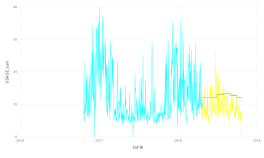

In [50]:
lstm_predictions = map(only, lstm_model.(df_test[:, :DATE]))
lstm_plot = plot_compare(df_test[:, :DATE], lstm_predictions)
draw(SVG(1000px, 600px), lstm_plot)

### Time-warping invariance

$z(t)$ — continuous time-domain signal
$$
h(t + \delta) \approx h(t) + \delta \frac{\mathrm{d}h(t)}{\mathrm{d}t}
$$

$$
\frac{\mathrm{d}h(t)}{\mathrm{d}t} = h(t + 1) - h(t) = R(z(t+1), h(t)) - h(t)
$$

$\tau : \mathbb{R}^{+} \to \mathbb{R}^{+}$ — monotonically increasing differentiable mapping between times

Consider **class of models** is _invariant_ to time-warping

$$
\frac{\mathrm{d}h(\tau(t))}{\mathrm{d}\tau(t)} = R(z(\tau(t+1)), h(\tau(t))) - h(\tau(t))
$$

$$
\frac{\mathrm{d}h(\tau(t))}{\mathrm{d}t} = \frac{\mathrm{d}h(\tau(t))}{\mathrm{d}\tau(t)} \frac{\mathrm{d}\tau(t)}{\mathrm{d}t} = \frac{\mathrm{d}\tau(t)}{\mathrm{d}t} R(z(\tau(t+1)), h(\tau(t))) - \frac{\mathrm{d}\tau(t)}{\mathrm{d}t} h(\tau(t))
$$

We need to introduce a learnable function Γ which approximates $\frac{\mathrm{d}\tau(t)}{\mathrm{d}t}$!

$$
h(\tau(t + \delta)) \approx h(\tau(t)) + \delta \frac{\mathrm{d}h(\tau(t))}{\mathrm{d}t}
$$

$$
\mathbf{h}^{(t+1)} = \mathbf{h}^{(t)} + \frac{\mathrm{d}\tau(t)}{\mathrm{d}t} R(\mathbf{z}^{(t+1)}, \mathbf{h}^{(t)}) - \frac{\mathrm{d}\tau(t)}{\mathrm{d}t} \mathbf{h}^{(t)} = \frac{\mathrm{d}\tau(t)}{\mathrm{d}t} R(\mathbf{z}^{(t+1)}, \mathbf{h}^{(t)}) + (1 - \frac{\mathrm{d}\tau(t)}{\mathrm{d}t}) \mathbf{h}^{(t)}
$$

$$
\mathbf{h}^{(t+1)} = \Gamma(\mathbf{z}^{(t+1)}, \mathbf{h}^{(t)}) R(\mathbf{z}^{(t+1)}, \mathbf{h}^{(t)}) + (1 - \Gamma(\mathbf{z}^{(t+1)}, \mathbf{h}^{(t)})) \mathbf{h}^{(t)}
$$

$$
\tau \quad \text{monotonically increasing} \implies \frac{\mathrm{d}\tau(t)}{\mathrm{d}t} > 0 \implies 0 < \Gamma(\mathbf{z}^{(t+1)}, \mathbf{h}^{(t)}) < 1
$$

$$
\Gamma(\mathbf{z}^{(t+1)}, \mathbf{h}^{(t)}) = \mathrm{\sigma}(\mathbf{W}_\Gamma \mathbf{z}^{(t+1)} + \mathbf{U}_\Gamma \mathbf{h}^{(t)} + \mathbf{b}_\Gamma)
$$

Mind vectors vs. scalars though! 😉

### Sequence-to-sequence